## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [101]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    img_size = (img.shape[1], img.shape[0])
    
    
# Calculate the 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

In [171]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.left_fit_history = [np.array([False])]
        self.right_fit_history = [np.array([False])]
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = [np.array([False])]  
        #y values for detected line pixels
        self.ally = []
        self.Minv = 0
        self.n = 10
line_info = Line()

## And so on and so forth...

In [103]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
# Apply a distortion correction to raw images.
def undistort(img):
    global mtx, dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


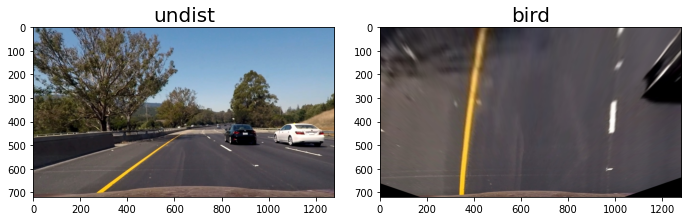

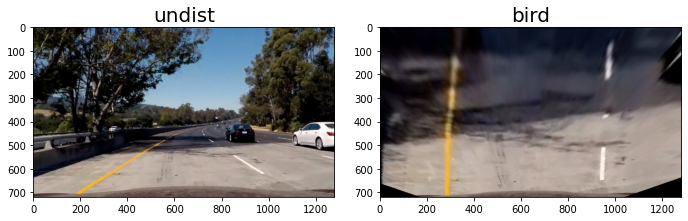

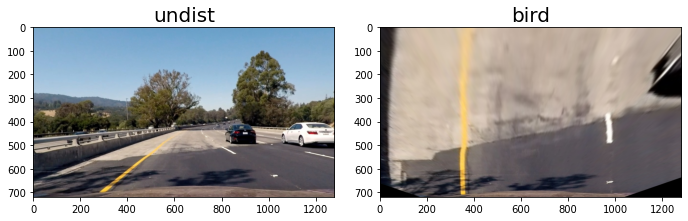

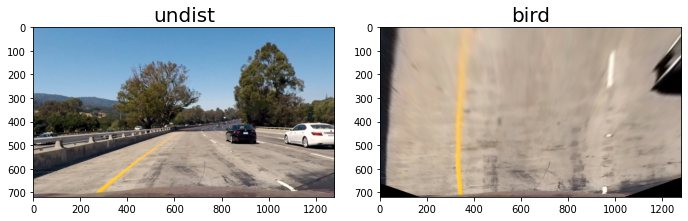

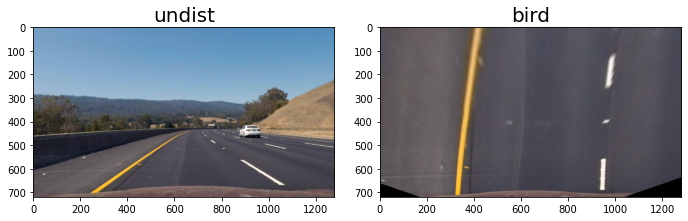

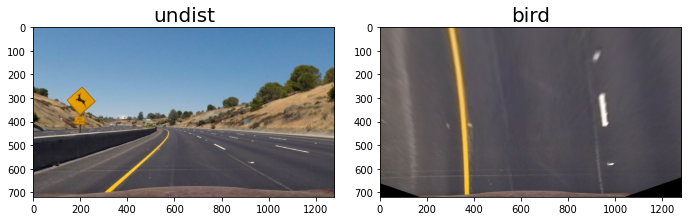

In [104]:
# Apply a perspective transform to rectify binary image ("birds-eye view").

def bird_eye(img):
    bottom_left = [220,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    return warped, Minv

for image in glob.glob('../test_images/test*.jpg'):
    img = cv2.imread(image)
    undist = undistort(img)
    bird_img, _ = bird_eye(undist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax1.set_title("undist", fontsize=20)
    ax2.imshow(cv2.cvtColor(bird_img, cv2.COLOR_BGR2RGB))
    ax2.set_title("bird", fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [106]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh =(0, 255)):
    # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Edit this function to create your own pipeline.
def hls_threshold(img, s_thresh=(170, 255)):
#     img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return s_binary
    
# Use color transforms, gradients, etc., to create a thresholded binary image.
def threshold_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 80))
#     cv2.imshow("gradx", gradx)
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 60))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    
    hls_binary = hls_threshold(img, s_thresh=(170, 255))
    
    combined = np.zeros_like(dir_binary)
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1)) | ( (hls_binary == 1))] = 1
    
    
    mask = np.zeros_like(combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(combined, mask)
    return thresholded

def display_images_all(img_info):
    f, axs = plt.subplots(1, len(img_info), figsize=(9,6))
#     print(len(img_info))
    f.tight_layout()
    i = 0
    for name, value in img_info.items():
        if len(img_info) == 1:
            axs.imshow(value)
            axs.set_title(name, fontsize=20)
        else:
            axs[i].imshow(value)
            axs[i].set_title(name, fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        i = i + 1

image = '../test_images/straight_lines1.jpg'
img = cv2.imread(image)
undist = undistort(img)
img_info = threshold_image(undist)

In [107]:
# Determine the curvature of the lane and vehicle position with respect to center.
def measure_curvature(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

def measure_center_offset(leftx, rightx, img_size):
    # compute the offset from the center
    lane_center = (leftx[719] + rightx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    return "Center offset: %.2f m" % center_offset_mtrs


In [166]:
# Detect lane pixels and fit to find the lane boundary.
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#     plt.plot(histogram)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, line_info):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        line_info.detected = True
    except TypeError:
        line_info.detected = False
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    line_info.current_fit = [left_fit, right_fit]
    line_info.left_fit_history.clear()
    line_info.right_fit_history.clear()
    line_info.left_fit_history.append(left_fit)
    line_info.right_fit_history.append(right_fit)
    
    line_info.allx = [left_fitx, right_fitx]
    line_info.ally = ploty
    
    return out_img, line_info

In [179]:
# Use the previous polynomial to skip the sliding window
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def get_average(fit_history):
    res = fit_history[0]
    for i in range(len(fit_history)):
        if i == 0:
            continue
        fit_history = fit_history + res
        
    return res / len(fit_history)
            
        
def search_around_poly(binary_warped, line_info):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
   
    # use average left/right-fit if deviation is too big
#     print("history:")
#     print (line_info.left_fit_history)
#     print (line_info.right_fit_history)
    left_fit_avg = get_average(line_info.left_fit_history)
    right_fit_avg = get_average(line_info.right_fit_history)
    
#     print (left_fit_avg)
#     print (right_fit_avg)
    
#     left_fit, right_fit = line_info.current_fit
    left_fit, right_fit = left_fit_avg, right_fit_avg
#     print("shape !!!!!!!")
#     print(left_fit.shape)
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    line_info.allx = [left_fitx, right_fitx]
    line_info.ally = ploty
    line_info.current_fit = [left_fit, right_fit]
    
    
    # use average left/right-fit if deviation is too big
#     left_fit_avg = get_av(line_info.left_fit_history)
#     right_fit_avg = np.average(line_info.right_fit_history)
    print (left_fit_avg)
    print(left_fit)
    print (right_fit_avg)
    print (right_fit)
    if abs(left_fit_avg[0] - left_fit[0])/ left_fit_avg[0] > 0.1 or abs(right_fit_avg[0] - right_fit[0]) / right_fit_avg[0] > 0.1:
        left_fit = left_fit_avg
        right_fit = right_fit_avg
        print("something wrong!!!!!!!")
    else:
        line_info.left_fit_history.append(left_fit)
        line_info.right_fit_history.append(right_fit)
        if len(line_info.left_fit_history) > line_info.n:
            line_info.left_fit_history = line_info.left_fit_history[1:]
            line_info.right_fit_history = line_info.right_fit_history[1:]
    
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    return result, line_info
# print(left_fit, right_fit)

# res_tmp  = search_around_poly(bird_img, line_info)
# plt.imshow(res_tmp)

In [177]:

def draw_final_image(warped, line_info, undist, Minv):
    left_fitx, right_fitx = line_info.allx
    ploty = line_info.ally
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#     plt.imshow(color_warp)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0]),flags=cv2.INTER_LINEAR) 
#     plt.imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result


[ 9.56254071e-05 -1.05777177e-01  3.62599446e+02]
[-1.05635766e-04  1.64956656e-01  3.03279147e+02]
[ 1.10504769e-04 -1.91697584e-01  1.00854180e+03]
[-3.29533460e-04  2.89031571e-01  8.84438816e+02]
something wrong!!!!!!!


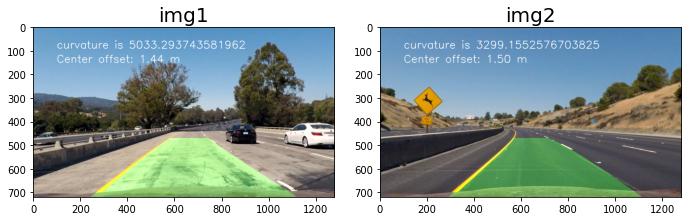

In [180]:
line_info.detected = False
# put it all together
def process_image(img):
    global line_info
    undist = undistort(img)
    thresholded = threshold_image(undist)
    bird_img, Minv = bird_eye(thresholded)
    
    if line_info.detected:
#         print ("detected!!!!!!!!!!!!!!!")
        res, line_info  = search_around_poly(bird_img, line_info)
        line_info.detected = True
    else:
        res, line_info  = fit_polynomial(bird_img, line_info)
    final_res = draw_final_image(bird_img, line_info, undist, Minv)
    left_fit, right_fit = line_info.current_fit
    ploty = line_info.ally


    left_curverad, right_curverad = measure_curvature(ploty, left_fit, right_fit)
    curvature_string = "curvature is " + str((left_curverad + right_curverad) / 2)


    left_fitx, right_fitx = line_info.allx
    center_offset = measure_center_offset(left_fitx, right_fitx, bird_img.shape)


    cv2.putText(final_res, curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(final_res, center_offset, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
#     print("debug!!!!!!!!!!!!!!!")

    return final_res
tmp_res1 = process_image(cv2.imread("../test_images/test1.jpg"))
tmp_res2 = process_image(cv2.imread("../test_images/test2.jpg"))
# tmp_res3 = process_image(cv2.imread("../test_images/test3.jpg"))
# tmp_res4 = process_image(cv2.imread("../test_images/test4.jpg"))
# tmp_res5 = process_image(cv2.imread("../test_images/test5.jpg"))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
f.tight_layout()
ax1.imshow(cv2.cvtColor(tmp_res1, cv2.COLOR_BGR2RGB))
ax1.set_title("img1", fontsize=20)
ax2.imshow(cv2.cvtColor(tmp_res2, cv2.COLOR_BGR2RGB))
ax2.set_title("img2", fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
# f.tight_layout()
# ax1.imshow(cv2.cvtColor(tmp_res1, cv2.COLOR_BGR2RGB))
# ax1.set_title("img3", fontsize=20)
# ax2.imshow(cv2.cvtColor(tmp_res2, cv2.COLOR_BGR2RGB))
# ax2.set_title("img4", fontsize=20)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [158]:
# video processing
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ../project_video_output.mp4.
Moviepy - Writing video ../project_video_output.mp4



t:  53%|█████▎    | 662/1260 [02:06<01:41,  5.91it/s, now=None]

TypeError: expected non-empty vector for x

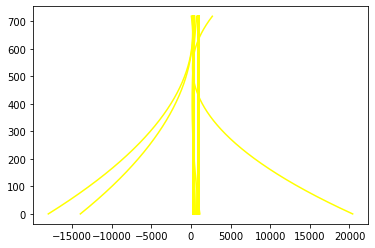

In [159]:
white_output = '../project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [80]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('../project_video_output.mp4'))